In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 60

In [2]:
image = np.load('./data/image.npy')
sinogram = np.load('./data/sinogram.npy')
r_axis = np.load('./data/r_axis.npy')
thetas = np.load('./data/thetas.npy')
dr = r_axis[1] - r_axis[0]

In [3]:
sinogram.shape

(320, 36)

Text(0, 0.5, '$r$')

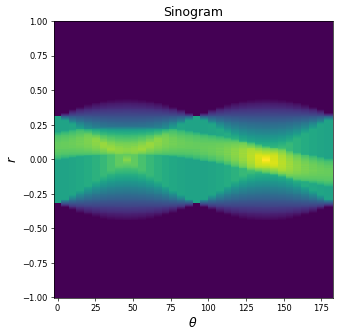

In [4]:
# Visualize
_r = np.linspace(-1, 1, sinogram.shape[0])
_theta = np.linspace(0, 180, sinogram.shape[1])
xv_rt, yv_rt = np.meshgrid(_theta,_r)
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.pcolor(xv_rt,yv_rt,sinogram, shading='auto')
ax.set_title('Sinogram',fontsize=15)
ax.set_xlabel(r'$\theta$',fontsize=15)
ax.set_ylabel(r'$r$',fontsize=15)

In [5]:
p = sinogram.copy() # this is the data coming from the CT scanner

In [6]:
from scipy.interpolate import RectBivariateSpline
p_interp = RectBivariateSpline(r_axis,thetas, p)

In [7]:
p_interp(0.22,40)

array([[0.5720763]])

In [8]:
# visualize the interpolated sinogram
# say that we want a 2-fold better resolution across r and a 3-fold across theta
_r_new = np.linspace(-1, 1, sinogram.shape[0]*2)
_theta_new = np.linspace(0, 180, sinogram.shape[1]*3)
xv_rt_new, yv_rt_new = np.meshgrid(_theta_new,_r_new)
# xv_rt_new, yv_rt_new = np.meshgrid(_theta_new,_r_new)

In [9]:
python_efficient = True
python_efficient = False

In [10]:
if python_efficient:
    sinogram_interp = np.vectorize(p_interp)(yv_rt_new, xv_rt_new)# same speed, less intuitive, less code
else:
    sinogram_interp = np.zeros((len(_r_new),len(_theta_new)))
    for r_count, r_value in enumerate(_r_new):
        for theta_count, theta_value in enumerate(_theta_new):
            sinogram_interp[r_count,theta_count] = p_interp(r_value,theta_value)

/tmp/ipykernel_80156/705600127.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sinogram_interp[r_count,theta_count] = p_interp(r_value,theta_value)


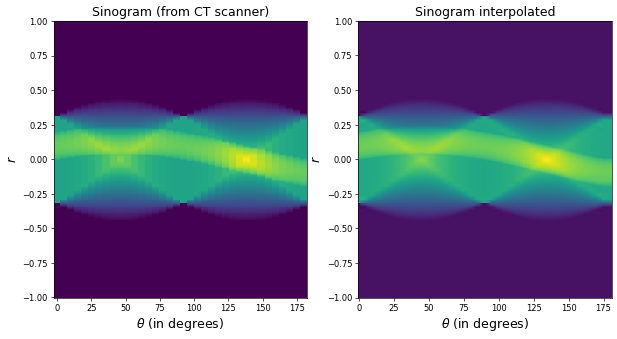

In [11]:
# Visualize
fig, ax = plt.subplots(1,2, figsize=(12,6))

ax[0].pcolor(xv_rt,yv_rt,sinogram, shading='auto')
ax[0].set_title('Sinogram (from CT scanner)',fontsize=15)
ax[0].set_xlabel(r'$\theta$ (in degrees)',fontsize=15)
ax[0].set_ylabel(r'$r$',fontsize=15)

ax[1].pcolor(xv_rt_new,yv_rt_new,sinogram_interp, shading='auto')
ax[1].set_title('Sinogram interpolated',fontsize=15)
ax[1].set_xlabel(r'$\theta$ (in degrees)',fontsize=15)
ax[1].set_ylabel(r'$r$',fontsize=15)
plt.show()

In [12]:
thetas_rad = np.deg2rad(thetas)
p_interp = RectBivariateSpline(r_axis, thetas_rad, p)


In [13]:
Delta_theta = thetas_rad[1] - thetas_rad[0]

_ = np.linspace(-1, 1, image.shape[0])

f_BP = np.zeros((len(_),len(_)))

for x_count, x_value in enumerate(_):
    for y_count, y_value in enumerate(_):
        r_values = x_value*np.cos(thetas_rad) + y_value*np.sin(thetas_rad)
        
        f_BP[x_count,y_count] = p_interp(r_values, thetas_rad,grid=False).sum()*Delta_theta

In [14]:
'''alternative'''
# Delta_theta = thetas_rad[1] - thetas_rad[0]

# _ = np.linspace(-1, 1, image.shape[0])
# xv, yv = np.meshgrid(_,_)


# def sum_of_p_at_any_x_y_theta(x,y):
#     return p_interp(x*np.cos(thetas_rad)+y*np.sin(thetas_rad), thetas_rad, grid=False).sum() * Delta_theta

# f_BP = np.vectorize(sum_of_p_at_any_x_y_theta)(xv,yv)

'alternative'

In [15]:
f_BP.shape

(320, 320)

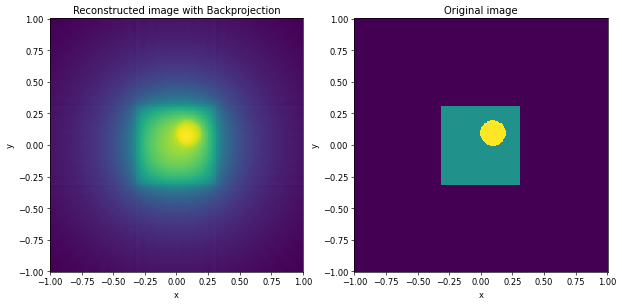

In [16]:
# Define some image pixel coordinates
_ = np.linspace(-1, 1, image.shape[0])
xv, yv = np.meshgrid(_,_)


fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].pcolor(xv,yv,f_BP, shading='auto')
ax[0].set_title('Reconstructed image with Backprojection')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_aspect('equal')

ax[1].pcolor(xv,yv,image, shading='auto')
ax[1].set_title('Original image')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_aspect('equal')
plt.show()

In [17]:
def find_all_y_given_x_coordinate(x_coord,xv,yv):

    resolution = np.abs(xv[0,1]-xv[0,0])
    a = np.where(np.abs(xv-x_coord) <= resolution)

    even = [x for x in range(len(a[0])) if x%2==0]
    odd = [x for x in range(len(a[0])) if x%2!=0]

    if x_coord>=0:
        idxs = (a[0][even],a[1][even])
    else:
        idxs = (a[0][odd],a[1][odd])
    return idxs

def find_all_x_given_y_coordinate(y_coord,xv,yv):

    resolution = np.abs(yv[1,0]-yv[0,0])
    a = np.where(np.abs(yv-y_coord) <= resolution)

    even = [x for x in range(len(a[0])) if x%2==0]
    odd = [x for x in range(len(a[0])) if x%2!=0]
    lenA = int(len(a[0])/2)
    if y_coord>=0:
        idxs = (a[0][0:lenA],a[1][0:lenA])
    else:
        idxs = (a[0][lenA:],a[1][lenA:])
    return idxs

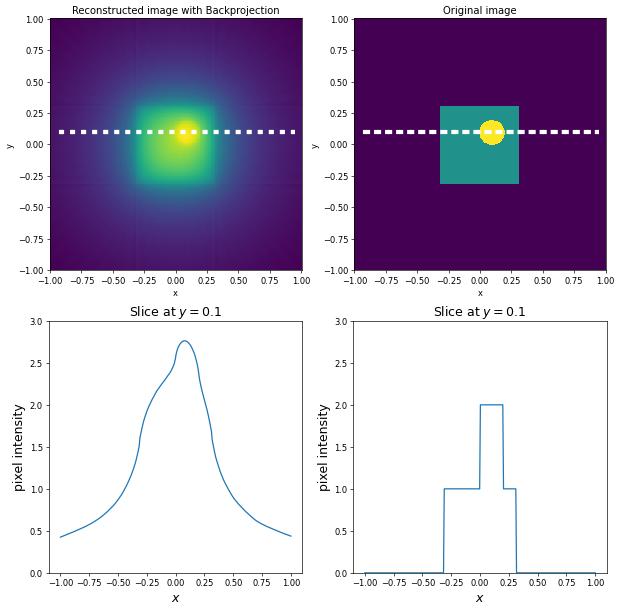

In [18]:
fig, ax = plt.subplots(2,2, figsize=(12,12))


y_coord = 0.1
idxs = find_all_x_given_y_coordinate(y_coord,xv,yv)

ax[0][0].pcolor(xv,yv,f_BP, shading='auto')
ax[0][0].set_title('Reconstructed image with Backprojection')
ax[0][0].set_xlabel('x')
ax[0][0].set_ylabel('y')
ax[0][0].set_aspect('equal')
ax[0][0].arrow(-0.95, y_coord, 1.9, 0, head_width=0.0, head_length=0.0,lw=5, fc='white', ec='white',ls=':')


ax[0][1].pcolor(xv,yv,image, shading='auto')
ax[0][1].set_title('Original image')
ax[0][1].set_xlabel('x')
ax[0][1].set_ylabel('y')
ax[0][1].set_aspect('equal')
ax[0][1].arrow(-0.95, y_coord, 1.9, 0, head_width=0.0, head_length=0.0,lw=5, fc='white', ec='white',ls=':')

ax[1][0].plot(r_axis,f_BP[idxs])
ax[1][0].set_xlabel(r'$x$',fontsize=15)
ax[1][0].set_ylabel('pixel intensity',fontsize=15)
ax[1][0].set_title(r'Slice at $y=$'+str(y_coord),fontsize=15)
ax[1][0].set_ylim([0,3])

ax[1][1].plot(r_axis,image[idxs])
ax[1][1].set_xlabel(r'$x$',fontsize=15)
ax[1][1].set_ylabel('pixel intensity',fontsize=15)
ax[1][1].set_title(r'Slice at $y=$'+str(y_coord),fontsize=15)
ax[1][1].set_ylim([0,3])


plt.show()

# Filtered back projection

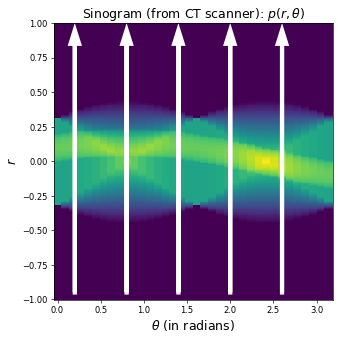

In [19]:
# Visualize
fig, ax = plt.subplots( figsize=(6,6))

_r = np.linspace(-1, 1, p.shape[0])
_theta_rad = np.deg2rad(np.linspace(0, 180, p.shape[1]))
xv_rt_rad, yv_rt_rad = np.meshgrid(_theta_rad,_r)

ax.pcolor(xv_rt_rad,yv_rt_rad,p, shading='auto')
ax.set_title(r'Sinogram (from CT scanner): $p(r,\theta)$',fontsize=15)
ax.set_xlabel(r'$\theta$ (in radians)',fontsize=15)
ax.set_ylabel(r'$r$',fontsize=15)

ax.arrow(0.2, -0.95, 0.0, 1.8, head_width=0.1, head_length=0.1,lw=5, fc='white', ec='white',ls='-')
ax.arrow(0.8, -0.95, 0.0, 1.8, head_width=0.1, head_length=0.1,lw=5, fc='white', ec='white',ls='-')
ax.arrow(1.4, -0.95, 0.0, 1.8, head_width=0.1, head_length=0.1,lw=5, fc='white', ec='white',ls='-')
ax.arrow(2.0, -0.95, 0.0, 1.8, head_width=0.1, head_length=0.1,lw=5, fc='white', ec='white',ls='-')
ax.arrow(2.6, -0.95, 0.0, 1.8, head_width=0.1, head_length=0.1,lw=5, fc='white', ec='white',ls='-')
plt.show()

In [20]:
r_axis[1]-r_axis[0]

0.006269592476489061

In [21]:
# Import all things for the Fast Fourier Transform
from scipy.fft import fft, fftfreq

P = fft(p, axis=0) # perform along all the rows
nu = fftfreq(P.shape[0], d=r_axis[1]-r_axis[0])

In [22]:
# this is for visualization
sort_nu = np.argsort(nu)
Psort = P[sort_nu,:]
nu_sort = nu[sort_nu]

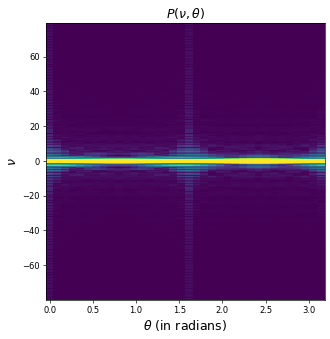

In [23]:
# Visualize
fig, ax = plt.subplots( figsize=(6,6))


_theta_rad = np.deg2rad(np.linspace(0, 180, p.shape[1]))
xv_nut_fft, yv_nut_rad = np.meshgrid(_theta_rad,nu_sort)

Pabs = np.abs(Psort)

ax.pcolor(xv_nut_fft,yv_nut_rad,Pabs, shading='auto',vmin=0,vmax=Pabs.max()*0.25)
ax.set_title(r'$P(\nu ,\theta)$',fontsize=15)
ax.set_xlabel(r'$\theta$ (in radians)',fontsize=15)
ax.set_ylabel(r'$\nu$',fontsize=15)
plt.show()

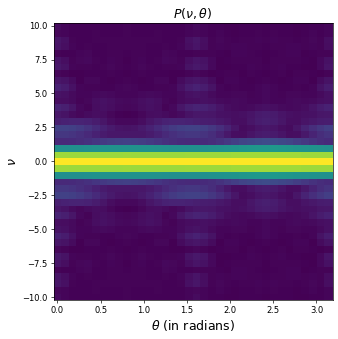

In [24]:
# Visualize
fig, ax = plt.subplots( figsize=(6,6))


_theta_rad = np.deg2rad(np.linspace(0, 180, p.shape[1]))
xv_nut_fft, yv_nut_rad = np.meshgrid(_theta_rad,nu_sort)

# ax.pcolor(xv_nut_fft,yv_nut_rad,np.abs(P), shading='auto')
Pabs = np.abs(Psort)
# Pabs = P.real

zoom_frequerncy = 10
xv_nut_fft = xv_nut_fft[np.abs(nu_sort)<zoom_frequerncy,:]
yv_nut_rad = yv_nut_rad[np.abs(nu_sort)<zoom_frequerncy,:]
Pabs = Pabs[np.abs(nu_sort)<zoom_frequerncy,:]
# idxs_display = np.where(np.abs(xv_nut_fft)<=20)
# # idxs_display = np.abs(xv_nut_fft)<=20

m=ax.pcolor(xv_nut_fft,yv_nut_rad,Pabs, shading='auto')
ax.set_title(r'$P(\nu ,\theta)$',fontsize=15)
ax.set_xlabel(r'$\theta$ (in radians)',fontsize=15)
ax.set_ylabel(r'$\nu$',fontsize=15)
# fig.colorbar(m)
plt.show()

In [25]:
integrand = P.T * np.abs(nu)
integrand = integrand.T

In [26]:
integrand.shape

(320, 36)

In [27]:
# Inverse fourier transform
from scipy.fft import ifft
p_prime = np.real(ifft(integrand, axis=0))      # try look at the function numpy.real_if_close(a, tol=100)

In [28]:
thetas_rad = np.deg2rad(thetas)
p_prime_interp = RectBivariateSpline(r_axis, thetas_rad, p_prime)

Delta_theta = thetas_rad[1] - thetas_rad[0]

_ = np.linspace(-1, 1, image.shape[0])
f_FBP = np.zeros((len(_),len(_)))

for x_count, x_value in enumerate(_):
    for y_count, y_value in enumerate(_):
        r_values = x_value*np.cos(thetas_rad) + y_value*np.sin(thetas_rad)
        
        f_FBP[x_count,y_count] = p_prime_interp(r_values, thetas_rad,grid=False).sum()*Delta_theta

In [29]:
# Alternative code
# def get_f_FBP(x,y):
#     return p_prime_interp(x*np.cos(thetas_rad)+y*np.sin(thetas_rad), thetas_rad, grid=False).sum() * Delta_theta
#'''
## Define some image pixel coordinates
#_ = np.linspace(-1, 1, image.shape[0])
#xv, yv = np.meshgrid(_,_)
#'''
# f_FBP = np.vectorize(get_f_FBP)(xv,yv)

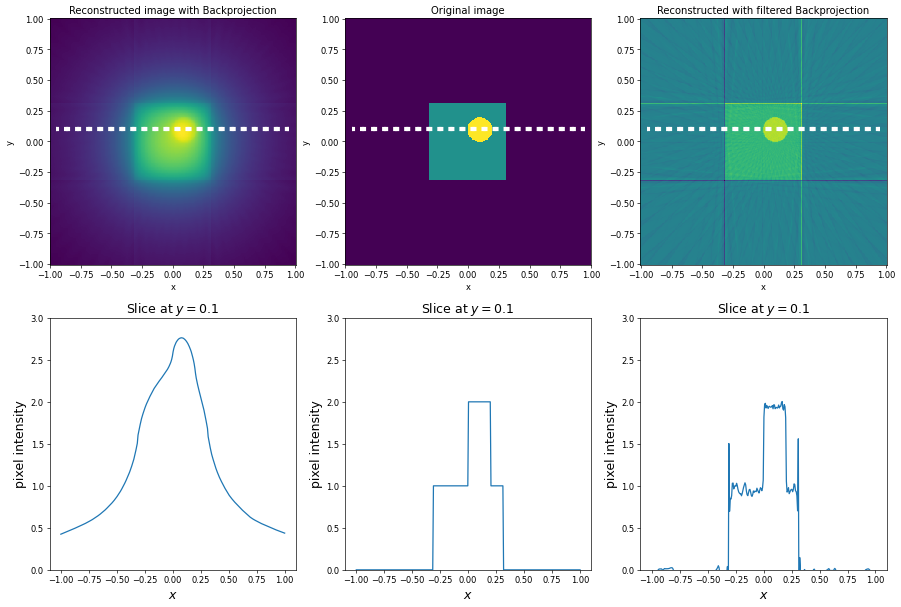

In [30]:
fig, ax = plt.subplots(2,3, figsize=(18,12))


y_coord = 0.1
idxs = find_all_x_given_y_coordinate(y_coord,xv,yv)

ax[0][0].pcolor(xv,yv,f_BP, shading='auto')
ax[0][0].set_title('Reconstructed image with Backprojection')
ax[0][0].set_xlabel('x')
ax[0][0].set_ylabel('y')
ax[0][0].set_aspect('equal')
ax[0][0].arrow(-0.95, y_coord, 1.9, 0, head_width=0.0, head_length=0.0,lw=5, fc='white', ec='white',ls=':')


ax[0][1].pcolor(xv,yv,image, shading='auto')
ax[0][1].set_title('Original image')
ax[0][1].set_xlabel('x')
ax[0][1].set_ylabel('y')
ax[0][1].set_aspect('equal')
ax[0][1].arrow(-0.95, y_coord, 1.9, 0, head_width=0.0, head_length=0.0,lw=5, fc='white', ec='white',ls=':')

ax[0][2].pcolor(xv,yv,f_FBP, shading='auto')
ax[0][2].set_title('Reconstructed with filtered Backprojection')
ax[0][2].set_xlabel('x')
ax[0][2].set_ylabel('y')
ax[0][2].set_aspect('equal')
ax[0][2].arrow(-0.95, y_coord, 1.9, 0, head_width=0.0, head_length=0.0,lw=5, fc='white', ec='white',ls=':')


ax[1][0].plot(r_axis,f_BP[idxs])
ax[1][0].set_xlabel(r'$x$',fontsize=15)
ax[1][0].set_ylabel('pixel intensity',fontsize=15)
ax[1][0].set_title(r'Slice at $y=$'+str(y_coord),fontsize=15)
ax[1][0].set_ylim([0,3])

ax[1][1].plot(r_axis,image[idxs])
ax[1][1].set_xlabel(r'$x$',fontsize=15)
ax[1][1].set_ylabel('pixel intensity',fontsize=15)
ax[1][1].set_title(r'Slice at $y=$'+str(y_coord),fontsize=15)
ax[1][1].set_ylim([0,3])

ax[1][2].plot(r_axis,f_FBP[idxs])
ax[1][2].set_xlabel(r'$x$',fontsize=15)
ax[1][2].set_ylabel('pixel intensity',fontsize=15)
ax[1][2].set_title(r'Slice at $y=$'+str(y_coord),fontsize=15)
ax[1][2].set_ylim([0,3])


plt.show()